# Sentence-BERT

In this notebook we'll take a look at how we can use transformer models (like BERT) to create sentence vectors for calculating similarity. Let's start by defining a few example sentences.

In [17]:
a = "purple is the best city in the forest"
b = "there is an art to getting your way and throwing bananas on to the street is not it"  # this is very similar to 'g'
c = "it is not often you find soggy bananas on the street"
d = "green should have smelled more tranquil but somehow it just tasted rotten"
e = "joyce enjoyed eating pancakes with ketchup"
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled"
g = "to get your way you must not bombard the road with yellow fruit"  # this is very similar to 'b'

Installing dependencies needed for this notebook

In [18]:
#!pip install -qU transformers

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Initialize our HF transformer model and tokenizer - using a pretrained SBERT model.

In [20]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

Tokenize all of our sentences.

In [21]:
tokens = tokenizer([a, b, c, d, e, f, g],
                   max_length=128,
                   truncation=True,
                   padding='max_length',
                   return_tensors='pt')


outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Here we can see the final embedding layer, *last_hidden_state*.

In [22]:
embeddings = outputs.last_hidden_state

mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()

Now we have a masking array that has an equal shape to our output `embeddings` - we multiply those together to apply the masking operation on our outputs.

In [23]:
masked_embeddings = embeddings * mask
masked_embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward>)

Sum the remaining embeddings along axis 1 to get a total value in each of our 768 values.

In [24]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([7, 768])

Next, we count the number of values that should be given attention in each position of the tensor (+1 for real tokens, +0 for non-real).

In [25]:
counted = torch.clamp(mask.sum(1), min=1e-9)
counted.shape

torch.Size([7, 768])

Finally, we get our mean-pooled values as the `summed` embeddings divided by the number of values that should be given attention, `counted`.

In [26]:
mean_pooled = summed / counted
mean_pooled.shape

torch.Size([7, 768])

Now we have our sentence vectors, we can calculate the cosine similarity between each.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [28]:
# convert to numpy array from torch tensor
mean_pooled = mean_pooled.detach().numpy()

# calculate similarities (will store in array)
scores = np.zeros((mean_pooled.shape[0], mean_pooled.shape[0]))
for i in range(mean_pooled.shape[0]):
    scores[i, :] = cosine_similarity(
        [mean_pooled[i]],
        mean_pooled
    )[0]

In [54]:
scores

array([[ 0.99999994,  0.08410864,  0.19932942,  0.16149577,  0.0628436 ,
        -0.16888835,  0.15908465],
       [ 0.08410864,  1.00000012,  0.66887045,  0.15511377, -0.04434279,
        -0.08248205,  0.53869855],
       [ 0.19932942,  0.66887045,  1.00000012,  0.31775126,  0.11580173,
        -0.0993001 ,  0.57613033],
       [ 0.16149577,  0.15511377,  0.31775126,  0.99999994,  0.22724755,
         0.05825395,  0.21090063],
       [ 0.0628436 , -0.0443428 ,  0.11580173,  0.22724755,  1.        ,
         0.07467985,  0.01525629],
       [-0.16888835, -0.08248205, -0.0993001 ,  0.05825395,  0.07467984,
         0.99999994, -0.03223572],
       [ 0.15908468,  0.53869843,  0.57613033,  0.21090065,  0.01525629,
        -0.03223572,  1.00000012]])

## Show similarity score of SBERT

We can visualize these scores using `matplotlib`.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

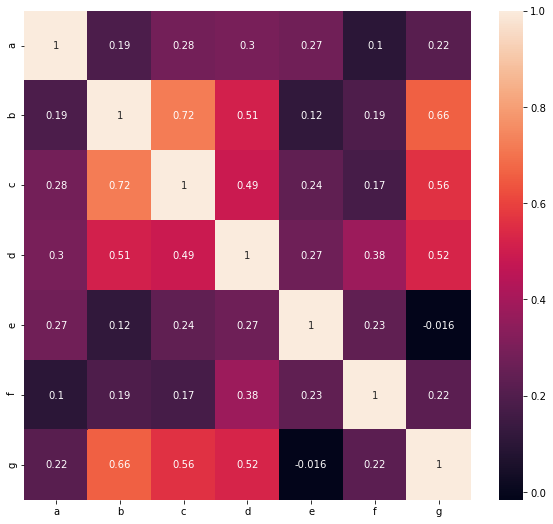

In [31]:
plt.figure(figsize=(10,9))
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
sns.heatmap(scores, xticklabels=labels, yticklabels=labels, annot=True)


In [32]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-large-nli-stsb-mean-tokens')
# model = AutoModel.from_pretrained('sentence-transformers/bert-large-nli-stsb-mean-tokens')


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentence embeddings:
tensor([[-0.3931,  0.0389,  1.9874,  ..., -0.6094, -1.0946,  0.3265],
        [ 0.0615,  0.3274,  1.8332,  ..., -0.1299,  0.4609,  0.2404]])


# SimCSE

In [33]:
from transformers import AutoModel, AutoTokenizer

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

# tokenizer.save_pretrained(os.path.expanduser('~/Documents/Data/transformers_models/sup-simcse-bert-base-uncased'))
# model.save_pretrained(os.path.expanduser('~/Documents/Data/transformers_models/sup-simcse-bert-base-uncased'))

a = "purple is the best city in the forest"
b = "there is an art to getting your way and throwing bananas on to the street is not it"  # this is very similar to 'g'
c = "it is not often you find soggy bananas on the street"
d = "green should have smelled more tranquil but somehow it just tasted rotten"
e = "joyce enjoyed eating pancakes with ketchup"
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled"
g = "to get your way you must not bombard the road with yellow fruit"  # this is very similar to 'b'

# Tokenize input texts
texts = [
    "There's a kid on a skateboard.",
    "A kid is skateboarding.",
    "A kid is inside the house."
]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
import torch
from scipy.spatial.distance import cosine

# Get the embeddings
with torch.no_grad():
    embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output

# Calculate cosine similarities
# Cosine similarities are in [-1, 1]. Higher means more similar
cosine_sim_0_1 = 1 - cosine(embeddings[0], embeddings[1])
cosine_sim_0_2 = 1 - cosine(embeddings[0], embeddings[2])

print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[1], cosine_sim_0_1))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (texts[0], texts[2], cosine_sim_0_2))

Cosine similarity between "There's a kid on a skateboard." and "A kid is skateboarding." is: 0.943
Cosine similarity between "There's a kid on a skateboard." and "A kid is inside the house." is: 0.439


In [36]:
tokens = tokenizer([a, b, c, d, e, f, g],
                   max_length=128,
                   truncation=True,
                   padding='max_length',
                   return_tensors='pt')

# Get the embeddings
with torch.no_grad():
    embeddings = model(**tokens, output_hidden_states=True, return_dict=True).pooler_output

b_c = 1 - cosine(embeddings[1], embeddings[2]) # b_c:0.72
b_c

0.6688703894615173

In [38]:
a_f = 1 - cosine(embeddings[0], embeddings[5]) # a_f:0.1
a_f

-0.16888834536075592

In [39]:
a_c = 1 - cosine(embeddings[0], embeddings[2]) # a_c:0.28
a_c


0.19932939112186432

In [42]:

b_g = 1 - cosine(embeddings[1], embeddings[6]) # b_g:0.66
b_g

0.5386984944343567

In [43]:
embeddings.shape

torch.Size([7, 768])

In [49]:

# calculate similarities (will store in array)
scores = np.zeros((embeddings.shape[0], embeddings.shape[0]))
for i in range(embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [embeddings[i]],
        embeddings
    )[0]
    
    

In [53]:
scores

array([[ 0.99999994,  0.08410864,  0.19932942,  0.16149577,  0.0628436 ,
        -0.16888835,  0.15908465],
       [ 0.08410864,  1.00000012,  0.66887045,  0.15511377, -0.04434279,
        -0.08248205,  0.53869855],
       [ 0.19932942,  0.66887045,  1.00000012,  0.31775126,  0.11580173,
        -0.0993001 ,  0.57613033],
       [ 0.16149577,  0.15511377,  0.31775126,  0.99999994,  0.22724755,
         0.05825395,  0.21090063],
       [ 0.0628436 , -0.0443428 ,  0.11580173,  0.22724755,  1.        ,
         0.07467985,  0.01525629],
       [-0.16888835, -0.08248205, -0.0993001 ,  0.05825395,  0.07467984,
         0.99999994, -0.03223572],
       [ 0.15908468,  0.53869843,  0.57613033,  0.21090065,  0.01525629,
        -0.03223572,  1.00000012]])

## Show similarity score of SimCSE

<AxesSubplot:>

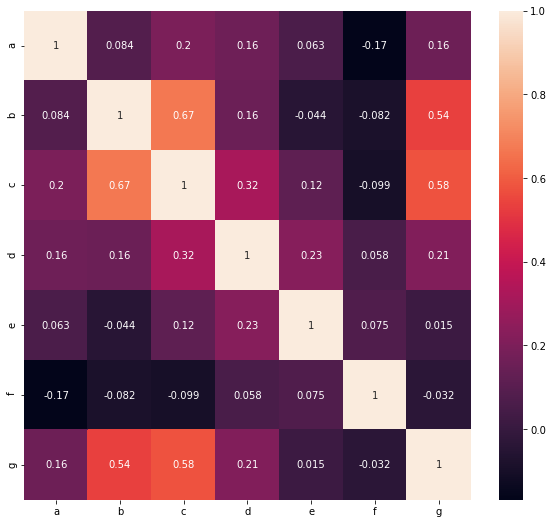

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,9))
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
sns.heatmap(scores, xticklabels=labels, yticklabels=labels, annot=True)
